In [858]:
import numpy as np
import pandas as pd

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df != "******").all(axis=1)]
    
    col_map = {
        "długośćmm": "dlugoscmm",
        "szerokośćmm": "szerokoscmm",
        "kąt": "kat",
        "obwódmm": "obwodmm",
        "średnica_fereta_hmm": "srednica_fereta_hmm",
        "średn._martinamm": "sredn._martinamm",
        "średn._sitowamm": "sredn._sitowamm",
        "średnia_jaskrawość": "srednia_jaskrawosc"
    }

    if "długośćmm" in df.columns:
        df = df.rename(columns=col_map)
        if "szerokoscmm" in df.columns:
            df["szerokoscmm"] = df["szerokoscmm"].astype(np.float64)

    return df


In [ ]:
import pandas as pd
import cv2
import numpy as np

def process_one_image(CSV_PATH_CORRECT = 'KolejnyTest/5M/x/report_5_x.csv',CSV_PATH_PREDICTED = 'KolejnyTest/5M/x/report_5_x.csv',IMAGE_PATH = f'KolejnyTest/5M/x/a.jpg'   ,OUTPUT_PATH = f'KolejnyTest/5M/x/a_marked.jpg'):
    # === CONFIG ===
            # Path to the original image
        # Where to save the output image

    # === LOAD IMAGE AND DATA ===
    img = cv2.imread(IMAGE_PATH)
    df_real = preprocess_df(pd.read_csv(CSV_PATH_CORRECT))
    df_predicted = preprocess_df(pd.read_csv(CSV_PATH_PREDICTED))

    height, width = img.shape[:2]

    # === DRAW OBJECTS ===
    for i, row in df_real.iterrows():
        try:
            # Extract pixel coordinates
            x = int(row['xpix.'])
            y = int(row['ypix.'])
            
            # Extract size in mm → convert to pixels if needed (assuming 1mm = 10px for now, adjust as needed)
            width_mm = float(row['szerokoscmm'])
            height_mm = float(row['dlugoscmm'])
            angle = 90-float(row['kat'])  # OpenCV uses negative angle for rotation
            # angle = float(row['kat'])  # OpenCV uses negative angle for rotation

            mm_to_px = 10  # ⬅️ Adjust this scaling factor based on your image resolution

            width_px = int(width_mm * mm_to_px)
            height_px = int(height_mm * mm_to_px)

            # Draw ellipse representing the object
            center = (x, height-y)
            # axes = (1, 1)
            axes = (width_px // 2, height_px // 2)
            color = (0, 255, 0)  # Green
            thickness = 1

            cv2.ellipse(img, center, axes, angle, 0, 360, color, thickness)

            # Optional: draw ID
            cv2.putText(img, str(int(row['nr.'])), (x + 5, height - y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
        except Exception as e:
            print(e)

    
    for i, row in df_predicted.iterrows():
        try:
            # Extract pixel coordinates
            x = int(row['xpix.'])
            y = int(row['ypix.'])
            
            # Extract size in mm → convert to pixels if needed (assuming 1mm = 10px for now, adjust as needed)
            width_mm = float(row['szerokoscmm'])
            height_mm = float(row['dlugoscmm'])
            # angle = 90-float(row['kat'])  # OpenCV uses negative angle for rotation
            angle = float(row['kat'])  # OpenCV uses negative angle for rotation

            mm_to_px = 10  # ⬅️ Adjust this scaling factor based on your image resolution

            width_px = int(width_mm * mm_to_px)
            height_px = int(height_mm * mm_to_px)

            # Draw ellipse representing the object
            center = (x, height-y)
            # axes = (1, 1)
            axes = (width_px // 2, height_px // 2)
            color = (0, 0, 255)  # Red
            thickness = 1

            cv2.ellipse(img, center, axes, angle, 0, 360, color, thickness)

            # Optional: draw ID
            # cv2.putText(img, str(int(row['nr.'])), (x + 5, height - y - 5),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
        except Exception as e:
            print(e)

    # === SAVE RESULT ===
    cv2.imwrite(OUTPUT_PATH, img)
    print(f"Image saved to {OUTPUT_PATH}")

In [860]:
import os
import pandas as pd

def load_dfs_from_path(path="example"):

    combined_df = []

    for entry in os.scandir(path):  
        if entry.is_file() and entry.name.endswith(".csv"):
            df = pd.read_csv(entry.path)
            df = preprocess_df(df)
            combined_df.append(df)

    combined_df = pd.concat(combined_df, ignore_index=True)

    return combined_df

In [861]:
def get_individual_stats(df):
    df = preprocess_df(df)
    # Scaling
    df['dlugoscmm'] = df['dlugoscmm']/1.49
    df['szerokoscmm'] = df['szerokoscmm']/1.49
    df['powierzchniamm'] = df['powierzchniamm']/2.235

    # filtering the things that with high probability are not bacteria !TODO odkomentuj to po testach
    # df = df[df['dlugoscmm'] >= 0.2]
    # df = df[df['szerokoscmm'] <= 1.5]

    df['Pw'] = 3.14*(df['szerokoscmm']/2)**2+df['szerokoscmm']*(df['dlugoscmm']-df['szerokoscmm'])
    df['R'] = df['Pw'] / df['powierzchniamm']
    df['Dk'] = df['dlugoscmm']
    df['Sk'] = df['szerokoscmm']
    df['D/S'] = (df['Dk'] / df['Sk']).astype('float64')

    bacteria_types = []
    Dks = []
    Sks = []
    for idx,row  in df.iterrows():
        if row['dlugoscmm'] < 0.2 or row['szerokoscmm'] > 1.5:
            Dks.append(row['dlugoscmm'])
            Sks.append(row['szerokoscmm'])
            bacteria_types.append("Removed_dim")
        elif row['R'] > 1.2:
            Dks.append(row['szerokoscmm'])
            Sks.append(row['Pw']*0.8)
            bacteria_types.append("Krzywe")
        else:
            Dks.append(row['dlugoscmm'])
            Sks.append(row['szerokoscmm'])
            if round(row['D/S'],15) > 1.5:
                bacteria_types.append("Pałeczki")
            else:
                bacteria_types.append("Ziarniaki")
    df['bacteria_type'] = bacteria_types
    df['Dk'] = Dks
    df['Sk'] = Sks

    df['Ob'] =(3.14*(df['Sk']**3)/6)+(3.14*((df['Sk']**2)/4)*(df['Dk']-df['Sk']))
    # !TODO remove this
    # df = df[df['Ob']>0]
    df.loc[df['Ob'] <= 0, 'bacteria_type'] = "removed_ob"
    df['Ob'] = np.abs(df['Ob'])
    # -----------------

    df['bialko'] = 104.5 * (df['Ob']**0.59)
    df['wegiel'] = 0.86 * df['bialko']

    return df

In [862]:
def get_stats_for_bacteria_types(df,probe_volume_ml = 6):
    grouped = df.groupby("bacteria_type")
    result_count = grouped.size().reset_index(name="count")
    result = grouped["Ob"].mean().reset_index()

    result['bialko'] = 104.5 * (result['Ob']**0.59)
    result['wegiel'] = 0.86 * result['bialko']
    result['count_in_1_ml']=((result_count['count']*48097.39)/10)/(probe_volume_ml)
    result['biomasa'] =(((104.5*result['Ob']**0.59)*0.86)*result['count_in_1_ml'])/1000000

    return result

In [863]:
import numpy as np

def get_stats_for_for_ob_bins(df,probe_volume_ml = 6):
    bins = [0, 0.1, 0.2, 0.5, 1.0, float("inf")]
    labels = ["<=0.1", "0.1–0.2", "0.2–0.5", "0.5–1.0", ">1.0"]

    df["Ob_bucket"] = pd.cut(df["Ob"], bins=bins, labels=labels, right=True)

    grouped = df.groupby(["bacteria_type", "Ob_bucket"], observed=True)
    result_bio_stats = grouped.size().reset_index(name="count")

    total_bacteria_count = np.sum(result_bio_stats['count'])
    total_bacteria_count_1_ml = ((np.sum(result_bio_stats['count'])*48097.39)/10)/(probe_volume_ml)

    result_bio_stats['count_in_1_ml']=((result_bio_stats['count']*48097.39)/10)/(probe_volume_ml)
    result_bio_stats['bio_diversity'] =((result_bio_stats['count_in_1_ml']+1)/total_bacteria_count_1_ml)*np.log10((result_bio_stats['count_in_1_ml']+1)/total_bacteria_count_1_ml)

    return result_bio_stats

In [864]:
def get_speified_baceria_types_count(df):
    return df.groupby("bacteria_type").size().reset_index(name="count")

In [865]:
def get_shannon_index(result_bio_stats):
    return np.sum(result_bio_stats['bio_diversity'])*-1

In [866]:
import pandas as pd

def full_analyse(df,proube_volume_ml=6):
    df = preprocess_df(df)
    df = get_individual_stats(df)
    result = get_stats_for_bacteria_types(df,probe_volume_ml=proube_volume_ml)
    result_bio_stats = get_stats_for_for_ob_bins(df,probe_volume_ml=proube_volume_ml)
    specified_types_count_predicted =  get_speified_baceria_types_count(df)
    shannon_index = np.sum(result_bio_stats['bio_diversity'])*-1
    print(f"Shannon index: {shannon_index}")

    return specified_types_count_predicted,df

In [867]:
def compare_results(df_real, df_predicted,proube_volume_ml=6):
    print("real:")
    real_classif,real_df = full_analyse(df_real,proube_volume_ml=proube_volume_ml)
    print("predicted:")
    predicted_classif,predicted_df = full_analyse(df_predicted,proube_volume_ml=proube_volume_ml)
    real_classif = real_classif.add_suffix("_real")
    predicted_classif = predicted_classif.add_suffix("_predicted")
    merged = pd.merge(real_classif,predicted_classif,left_on="bacteria_type_real",right_on="bacteria_type_predicted", how="inner")
    merged = merged.drop(axis=1,columns=['bacteria_type_predicted'])
    merged = merged.rename(columns={"bacteria_type_real":"bacteria_type"})
    merged['error'] = merged['count_predicted']- merged['count_real']
    merged['relative_error'] = merged['error']/merged['count_real']
    return merged,real_df,predicted_df

In [868]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def conf_matrix(real_df,predicted_df):
    y_true = real_df['bacteria_type']
    y_pred = predicted_df['bacteria_type']

    cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_true.unique())
    disp.plot(cmap="Blues", xticks_rotation=45)


In [869]:
df = load_dfs_from_path("agata_1_y_no_model")
predicted_classif = full_analyse(df,proube_volume_ml=6)
print(predicted_classif)

Shannon index: 0.9252722551885972
(  bacteria_type  count
0        Krzywe     43
1      Pałeczki    112
2   Removed_dim      1
3     Ziarniaki     37,      nr.   xpix.  ypix.    xmm   ymm  powierzchniamm  dlugoscmm  szerokoscmm  \
0      1   950.5  937.5   95.1  93.8        0.487696   1.275168     0.201342   
1      2  1116.5  910.5  111.7  91.1        0.299776   0.805369     0.335570   
2      3   760.5  845.5   76.0  84.6        0.241611   0.671141     0.402685   
3      4   445.5  830.5   44.6  83.1        0.152125   0.536913     0.536913   
4      5  1068.5  789.5  106.9  79.0        0.407159   1.073826     0.469799   
..   ...     ...    ...    ...   ...             ...        ...          ...   
188   11   303.5  334.5   30.4  33.5        0.675615   1.275168     0.536913   
189   12   188.5  327.5   18.9  32.8        0.214765   0.604027     0.536913   
190   13   276.5  325.5   27.7  32.6        0.384787   0.939597     0.536913   
191   14   640.5  266.5   64.0  26.7        0.178

In [870]:
df = load_dfs_from_path("agata_1_y_real")
real_classif = full_analyse(df,proube_volume_ml=6)
print(real_classif)

Shannon index: 0.9356544010592158
(  bacteria_type  count
0        Krzywe     14
1      Pałeczki    204
2   Removed_dim      2
3     Ziarniaki    129
4    removed_ob      2,      nr.  xpix.  ypix.    xmm   ymm  powierzchniamm  dlugoscmm  szerokoscmm  \
0      1    529    914   52.9  91.4        0.519016   0.997723     0.553437   
1      2   1096    910  109.6  91.0        0.420582   1.148808     0.402685   
2      3   1253    851  125.3  85.1        0.322148   0.830155     0.408239   
3      4   1150    811  115.0  81.1        0.326622   0.785550     0.408239   
4      5   1177    781  117.7  78.1        0.612975   1.332177     0.474568   
..   ...    ...    ...    ...   ...             ...        ...          ...   
346   15    108    467   10.8  46.7        0.715884   1.189265     0.750358   
347   16     21    398    2.1  39.8        0.675615   0.960928     0.816478   
348   17    635    394   63.5  39.4        0.532438   1.383592     0.488598   
349   18    888    115   88.8  11.5 

In [871]:
df_real = load_dfs_from_path("agata_1_y_real_correct_index")
df_predicted = load_dfs_from_path("no_model_agata_4")
# df_predicted = load_dfs_from_path("agata_1_y_no_model_2")
# df_predicted['powierzchniamm'] *= 1.2
# df_predicted['dlugoscmm'] *= 1.1
# df_predicted['szerokoscmm'] *= 0.9

# df_predicted['szerokoscmm'] = df_real['szerokoscmm']
# df_predicted['dlugoscmm'] = df_real['dlugoscmm']
# df_predicted['powierzchniamm'] = df_real['powierzchniamm']
compared,real_df,predicted_df = compare_results(df_real=df_real,df_predicted=df_predicted,proube_volume_ml=6)
print(compared)

real:
Shannon index: 0.9714580520564581
predicted:
Shannon index: 0.8111132501179013
  bacteria_type  count_real  count_predicted  error  relative_error
0        Krzywe          10              126    116       11.600000
1      Pałeczki         124               28    -96       -0.774194
2   Removed_dim           2                1     -1       -0.500000
3     Ziarniaki          56               36    -20       -0.357143
4    removed_ob           1                2      1        1.000000


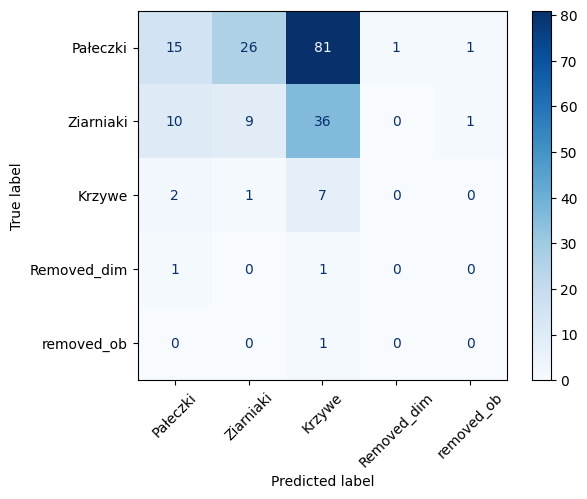

In [872]:
conf_matrix(real_df=real_df,predicted_df=predicted_df)

In [873]:
df_errors = pd.DataFrame()
df_errors['error_dlugoscmm'] = real_df['dlugoscmm']-predicted_df['dlugoscmm']
df_errors['error_szerokoscmm'] = real_df['szerokoscmm']-predicted_df['szerokoscmm']
df_errors['error_powierzchniamm'] = real_df['powierzchniamm']-predicted_df['powierzchniamm']
df_errors['error_R'] = real_df['R']-predicted_df['R']
df_errors['error_D/S'] = real_df['D/S']-predicted_df['D/S']
df_errors.corr()

,error_dlugoscmm,error_szerokoscmm,error_powierzchniamm,error_R,error_D/S
error_dlugoscmm,1.000000,0.577919,0.890461,0.573443,0.759360
error_szerokoscmm,0.577919,1.000000,0.801129,0.570556,0.025323
error_powierzchniamm,0.890461,0.801129,1.000000,0.444746,0.548454
error_R,0.573443,0.570556,0.444746,1.000000,0.108311
error_D/S,0.759360,0.025323,0.548454,0.108311,1.000000


In [874]:
df_real = pd.read_csv("agata_1_y_real_correct_index/raport_a3.csv")
df_predicted = pd.read_csv("no_model_agata_4/a3_raport_no_model.csv")


In [875]:
df_real

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,długośćmm,szerokośćmm,kąt,obwódmm,...,średn._martinamm,średn._sitowamm,średnia_jaskrawość,r,g,b,y,liczenie_obiektow_w,udzial_punktow,pole_obrazu_mm2
0,2,974,882,97.4,88.2,1.21,1.476482,0.943398,61.70,3.768320,...,1.1,1.044031,225.6,105.9,156.2,166.3,141.6,30,100.0,12288.0
1,3,146,827,14.6,82.7,0.62,1.000000,0.583095,36.87,2.627664,...,0.7,0.781025,221.2,115.4,166.6,184.4,152.6,30,100.0,12288.0
2,4,1223,766,122.3,76.6,1.02,1.392839,0.824621,68.96,3.631773,...,0.9,0.800000,226.5,104.8,158.8,171.7,143.4,30,100.0,12288.0
3,5,329,720,32.9,72.0,2.21,2.220360,1.140175,35.84,5.805614,...,1.8,1.272792,226.3,124.4,164.9,187.0,154.6,30,100.0,12288.0
4,6,944,699,94.4,69.9,0.69,1.170470,0.728011,19.98,2.987016,...,1.2,0.700000,212.4,118.6,161.4,168.6,148.8,30,100.0,12288.0
5,7,719,675,71.9,67.5,1.10,1.360147,0.860233,53.97,3.559765,...,1.2,0.989949,231.9,114.2,163.9,176.7,149.8,30,100.0,12288.0
6,8,206,621,20.6,62.1,2.11,2.256103,1.104536,77.20,5.896594,...,0.9,1.100000,229.4,112.4,158.5,182.5,146.7,30,100.0,12288.0
7,9,852,616,85.2,61.6,0.35,0.670820,0.538516,26.57,1.678353,...,0.6,0.500000,207.9,118.9,160.6,151.3,146.4,30,100.0,12288.0
8,10,1215,588,121.5,58.8,0.73,1.640122,0.500000,37.57,3.934074,...,1.0,0.721110,221.2,97.9,143.0,151.4,129.7,30,100.0,12288.0
9,11,409,549,40.9,54.9,0.53,0.921954,0.640312,130.60,2.497607,...,0.9,0.700000,219.6,132.6,182.4,191.1,167.7,30,100.0,12288.0


In [876]:
df_predicted

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,dlugoscmm,szerokoscmm,kat,obwodmm,...,sredn._martinamm,sredn._sitowamm,srednia_jaskrawosc,r,g,b,y,liczenie_obiektow_w,udzial_punktow,pole_obrazu_mm2
0,1,973.5,882.5,97.4,88.2,0.93,1.600000,0.9,18.13,4.252691,...,1.6,1.085240,144.9,109.5,158.6,167.4,144.9,1,10.8,10.2
1,2,145.5,827.5,14.6,82.8,0.54,1.021610,0.7,28.26,2.814214,...,1.0,0.829186,145.3,112.7,157.5,168.5,145.4,1,8.6,7.8
2,3,1222.5,766.5,122.2,76.7,1.04,1.546348,0.9,6.63,4.097056,...,1.5,1.150725,128.1,93.3,140.6,155.3,128.1,1,12.9,9.6
3,4,328.5,720.5,32.9,72.0,1.37,2.093570,0.9,52.31,4.887006,...,2.1,1.318322,186.5,155.7,197.4,211.0,186.5,1,11.6,13.7
4,5,943.5,699.5,94.4,70.0,0.60,1.145706,0.7,81.35,3.155635,...,1.1,0.870389,139.2,111.5,149.6,158.2,139.2,1,8.8,8.4
5,6,718.5,675.5,71.9,67.5,0.93,1.445289,0.9,31.95,3.862742,...,1.4,1.088169,147.0,113.2,159.5,171.1,147.0,1,10.8,10.2
6,7,205.5,621.5,20.6,62.2,1.48,2.402714,0.9,7.64,5.994112,...,2.4,1.372732,157.8,123.1,170.1,185.6,157.8,1,13.1,13.3
7,8,851.5,616.5,85.2,61.7,0.53,1.069651,0.8,125.56,3.062742,...,1.1,0.821472,112.8,91.8,122.3,119.3,112.8,1,9.8,6.8
8,9,1214.5,588.5,121.5,58.9,0.97,2.007490,0.7,51.60,5.169848,...,2.0,1.108457,104.5,78.6,113.8,124.4,104.5,1,11.6,10.2
9,10,408.5,549.5,40.9,55.0,0.53,1.000000,0.8,165.63,2.731371,...,1.0,0.821472,142.7,112.0,154.2,163.8,142.7,1,8.4,7.8


In [877]:
# df_predicted['powierzchniamm'] *= 1.1
# df_predicted['dlugoscmm'] *= 0.96
# df_predicted['szerokoscmm'] *= 0.96

In [878]:

# df_predicted['szerokoscmm'] = df_real['szerokośćmm']
# df_predicted['dlugoscmm'] = df_real['długośćmm']
# df_predicted['powierzchniamm'] = df_real['powierzchniamm']

In [879]:
compared,real_df,predicted_df = compare_results(df_real=df_real,df_predicted=df_predicted,proube_volume_ml=6)
print(compared)
mean_abs_erron = np.mean(np.abs(compared['relative_error']))

real:
Shannon index: 0.7325783444855738
predicted:
Shannon index: 0.6844180690882522
  bacteria_type  count_real  count_predicted  error  relative_error
0        Krzywe           1               15     14            14.0
1      Pałeczki          20                6    -14            -0.7
2     Ziarniaki           3                3      0             0.0


In [880]:
real_df['bacteria_type']

0      Pałeczki
1      Pałeczki
2      Pałeczki
3      Pałeczki
4      Pałeczki
5      Pałeczki
6      Pałeczki
7     Ziarniaki
8      Pałeczki
9     Ziarniaki
10     Pałeczki
11     Pałeczki
12    Ziarniaki
13     Pałeczki
14     Pałeczki
15       Krzywe
16     Pałeczki
17     Pałeczki
18     Pałeczki
19     Pałeczki
20     Pałeczki
21     Pałeczki
22     Pałeczki
23     Pałeczki
Name: bacteria_type, dtype: object

In [881]:
predicted_df['bacteria_type']

0        Krzywe
1     Ziarniaki
2      Pałeczki
3        Krzywe
4      Pałeczki
5        Krzywe
6        Krzywe
7        Krzywe
8        Krzywe
9        Krzywe
10       Krzywe
11    Ziarniaki
12     Pałeczki
13       Krzywe
14       Krzywe
15     Pałeczki
16     Pałeczki
17       Krzywe
18       Krzywe
19       Krzywe
20       Krzywe
21     Pałeczki
22    Ziarniaki
23       Krzywe
Name: bacteria_type, dtype: object

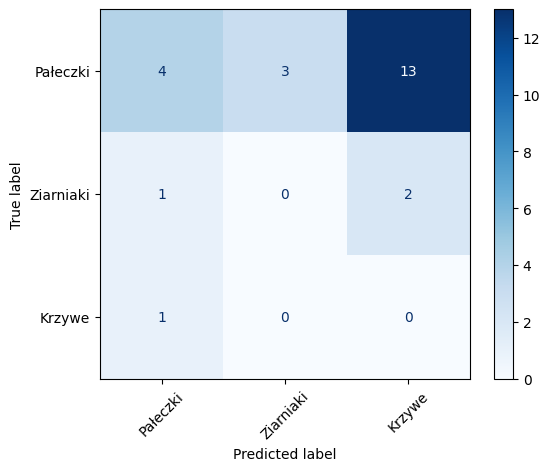

In [882]:
conf_matrix(real_df=real_df,predicted_df=predicted_df)

In [883]:
real_df[['nr.','powierzchniamm','dlugoscmm','szerokoscmm','Pw','R','D/S']].tail()

,nr.,powierzchniamm,dlugoscmm,szerokoscmm,Pw,R,D/S
19,21,0.608501,1.260959,0.573423,0.652368,1.072090,2.199004
20,22,0.085011,0.335570,0.189827,0.055953,0.658185,1.767767
21,23,0.362416,0.808161,0.429740,0.307593,0.848730,1.880581
22,24,0.098434,0.408239,0.134228,0.050923,0.517336,3.041381
23,25,0.568233,1.041891,0.684432,0.612387,1.077705,1.522271


In [884]:
predicted_df[['nr.','powierzchniamm','dlugoscmm','szerokoscmm','Pw','R','D/S']].tail()

,nr.,powierzchniamm,dlugoscmm,szerokoscmm,Pw,R,D/S
19,20,0.657718,1.342282,0.671141,0.804018,1.222435,2.000000
20,21,0.178971,0.552895,0.536913,0.234877,1.312376,1.029767
21,22,0.340045,0.868781,0.536913,0.404480,1.189491,1.618104
22,23,0.165548,0.564602,0.402685,0.192493,1.162763,1.402095
23,24,0.599553,1.140940,0.738255,0.725125,1.209444,1.545455


In [885]:
real_df['powierzchniamm']-predicted_df['powierzchniamm']

0     0.125280
1     0.035794
2    -0.008949
3     0.375839
4     0.040268
5     0.076063
6     0.281879
7    -0.080537
8    -0.107383
9     0.000000
10   -0.022371
11   -0.053691
12    0.326622
13   -0.008949
14   -0.129754
15   -0.058166
16    0.044743
17    0.143177
18   -0.022371
19   -0.049217
20   -0.093960
21    0.022371
22   -0.067114
23   -0.031320
Name: powierzchniamm, dtype: float64

In [886]:
real_df['dlugoscmm']-predicted_df['dlugoscmm']

0    -0.082898
1    -0.014504
2    -0.103026
3     0.085094
4     0.016620
5    -0.057142
6    -0.098397
7    -0.267672
8    -0.246555
9    -0.052380
10   -0.117777
11   -0.160701
12    0.031836
13   -0.092901
14   -0.274869
15   -0.110272
16    0.054190
17   -0.351207
18   -0.218217
19   -0.081323
20   -0.217324
21   -0.060620
22   -0.156363
23   -0.099049
Name: dlugoscmm, dtype: float64

In [887]:
real_df['szerokoscmm']-predicted_df['szerokoscmm']

0     0.029126
1    -0.078460
2    -0.050590
3     0.161192
4     0.018799
5    -0.026690
6     0.137273
7    -0.175492
8    -0.134228
9    -0.107173
10   -0.134228
11   -0.268456
12    0.229678
13   -0.260194
14   -0.227815
15    0.072688
16   -0.048315
17    0.145337
18   -0.107173
19   -0.097718
20   -0.347085
21   -0.107173
22   -0.268456
23   -0.053823
Name: szerokoscmm, dtype: float64

In [888]:
df_errors = pd.DataFrame()
df_errors['error_dlugoscmm'] = real_df['dlugoscmm']-predicted_df['dlugoscmm']
df_errors['error_szerokoscmm'] = real_df['szerokoscmm']-predicted_df['szerokoscmm']
df_errors['error_powierzchniamm'] = real_df['powierzchniamm']-predicted_df['powierzchniamm']
df_errors['error_R'] = real_df['R']-predicted_df['R']
df_errors['error_D/S'] = real_df['D/S']-predicted_df['D/S']
df_errors.corr()

,error_dlugoscmm,error_szerokoscmm,error_powierzchniamm,error_R,error_D/S
error_dlugoscmm,1.000000,0.407843,0.530183,0.450683,-0.182129
error_szerokoscmm,0.407843,1.000000,0.817422,0.733886,-0.805102
error_powierzchniamm,0.530183,0.817422,1.000000,0.316083,-0.568999
error_R,0.450683,0.733886,0.316083,1.000000,-0.697050
error_D/S,-0.182129,-0.805102,-0.568999,-0.697050,1.000000


In [889]:
for i in range(1,11):
    try:
        process_one_image(IMAGE_PATH=f'images_y/a{i}.jpg',CSV_PATH_CORRECT=f'agata_1_y_real_correct_index/raport_a{i}.csv',CSV_PATH_PREDICTED=f'no_model_agata_4/a{i}_raport_no_model.csv',OUTPUT_PATH=f'no_model_agata_4/a{i}_elipses_compare.jpg')
    except:
        continue

Image saved to no_model_agata_4/a1_elipses_compare.jpg
Image saved to no_model_agata_4/a3_elipses_compare.jpg
Image saved to no_model_agata_4/a4_elipses_compare.jpg
Image saved to no_model_agata_4/a5_elipses_compare.jpg
Image saved to no_model_agata_4/a6_elipses_compare.jpg
Image saved to no_model_agata_4/a7_elipses_compare.jpg
Image saved to no_model_agata_4/a8_elipses_compare.jpg
Image saved to no_model_agata_4/a9_elipses_compare.jpg
Image saved to no_model_agata_4/a10_elipses_compare.jpg
